<a href="https://colab.research.google.com/github/California3/super-resolution-resize-cv/blob/main/super_resolution_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Key Settings

In [43]:
FORCE_UPGRADE = False
COLAB_SPACE   = False
NEED_FITTING  = False

# Import Libraires

In [44]:
if COLAB_SPACE:
    from google.colab import drive
    drive.mount('/content/drive')

In [45]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: nvidia-smi: command not found


In [46]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 16.8 gigabytes of available RAM

Not using a high-RAM runtime


In [47]:
!pwd

/workspaces/super-resolution-resize-cv


In [48]:
!pip install chainer
!pip install tensorflow
# install opencv2
!pip install opencv-python
!pip install opencv-python-headless
# tqdm
!pip install tqdm

In [49]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from chainer import Chain
from chainer import functions as F
from chainer import links as L

# Copy Data To Local

In [50]:
if COLAB_SPACE:
    parents_loc = "/content/drive/MyDrive/ADV_CV_Code/"
    native_loc = "/content/native/"
    data_loc = native_loc + 'Dataset/Raw Data/'

    # if native_loc exists, then we are running on a local machine
    if os.path.exists(native_loc):
        print("Native location exists")
    else:
        # create native_loc
        os.mkdir(native_loc)
        # copy all files from parents_loc to native_loc
        !cp -r $parents_loc* $native_loc
        print("Copied files from parents_loc to native_loc")
else:
    parents_loc = ''
    data_loc = 'Dataset/Raw Data/'

MODEL_PATH = parents_loc + "final_model.h5"

# Load Data

In [51]:
# to get the files in proper order
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
high_img = []
low_img = []

path = data_loc + 'high_res'
path_low = data_loc + 'low_res'

files = os.listdir(path)
files = sorted_alphanumeric(files)

files_low = os.listdir(path_low)
files_low = sorted_alphanumeric(files_low)
for i in tqdm(files):
    if i == '855.jpg':
        break
    elif i in files_low:
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))

        img = cv2.imread(path_low + '/'+i,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))

  3%|▎         | 23/855 [00:00<00:03, 224.66it/s]

100%|██████████| 855/855 [00:03<00:00, 216.12it/s]


# Data Visualization

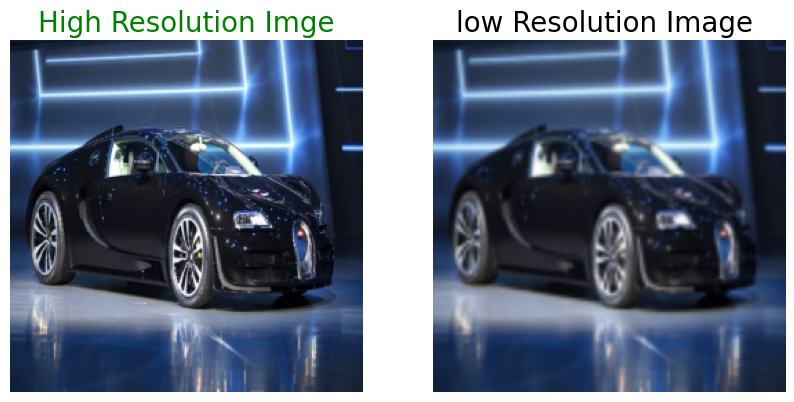

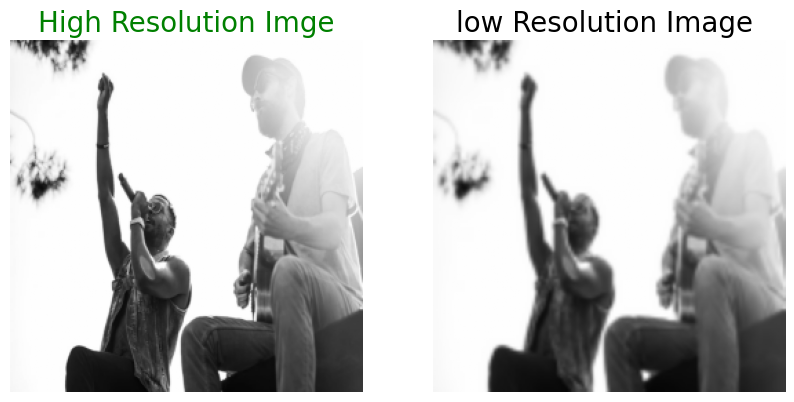

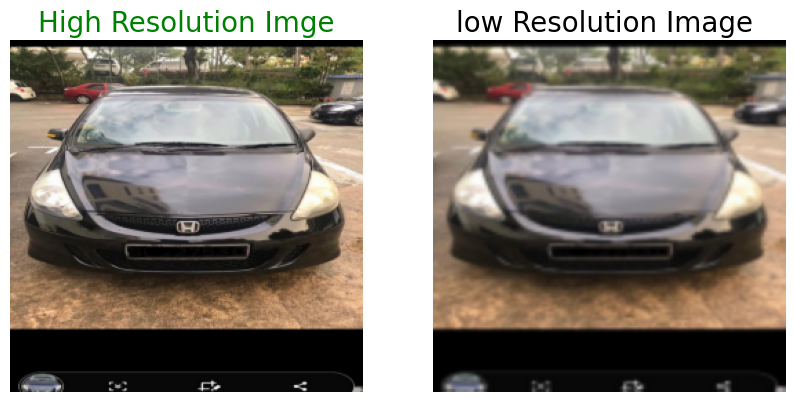

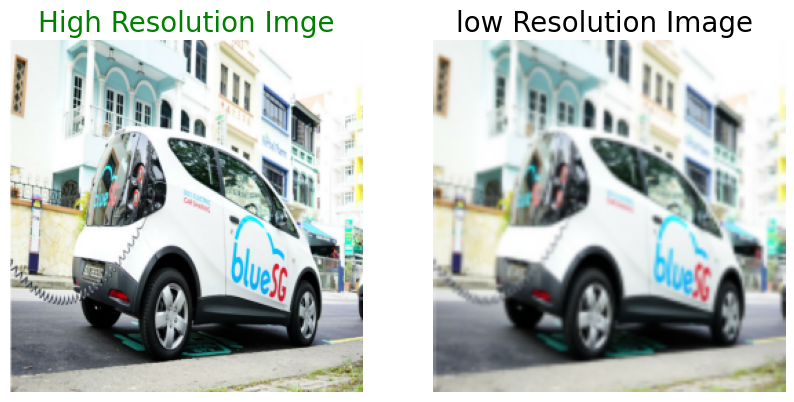

In [52]:
for i in range(4):
    a = np.random.randint(0,855)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis('off')

# Slicing and Reshaping Images

In [53]:
train_high_image = high_img[:700]
train_low_image = low_img[:700]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[700:830]
validation_low_image = low_img[700:830]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))


test_high_image = high_img[830:]
test_low_image = low_img[830:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)


Shape of training images: (700, 256, 256, 3)
Shape of test images: (25, 256, 256, 3)
Shape of validation images: (130, 256, 256, 3)


# Defining Model

In [54]:
from keras import layers
# Keep default functions.
def down_default(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample

def up_default(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

# Our new functions.
def up_resize_conv(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()

    upsample.add(layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='nearest'))
    upsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))

    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

def down_upgrade(filters , kernel_size, apply_batch_normalization = True):
    return down_default(filters , kernel_size, apply_batch_normalization)

# New Interface For model
def upgrade(type = ""):
    upsample = tf.keras.models.Sequential()
    if type == "upgrade" or FORCE_UPGRADE:
        pass
    else:
        pass
    return upsample

def up(filters, kernel_size, dropout = False, type = ''):
    if type == 'resize_conv' or FORCE_UPGRADE:
        return up_resize_conv(filters, kernel_size, dropout)
    else:
        return up_default(filters, kernel_size, dropout)

def down(filters , kernel_size, apply_batch_normalization = True, type = ""):
    if type == "upgrade" or FORCE_UPGRADE:
        return down_upgrade(filters , kernel_size, apply_batch_normalization)
    else:
        return down_default(filters , kernel_size, apply_batch_normalization)

def model():
    inputs = layers.Input(shape= [SIZE,SIZE,3])
    # convolutions down the stack
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    d5 = down(512,(3,3),True)(d4)

    # deconvolutions up the stack OR first upsampling then convolutions
    u1 = up(512,(3,3),False)(d5)
    d4_ = upgrade()(d4)
    u1 = layers.concatenate([u1,d4_])
    u2 = up(256,(3,3),False)(u1)
    d3_ = upgrade()(d3)
    u2 = layers.concatenate([u2,d3_])
    u3 = up(128,(3,3),False)(u2)
    d2_ = upgrade()(d2)
    u3 = layers.concatenate([u3,d2_])
    u4 = up(128,(3,3),False)(u3)
    d1_ = upgrade()(d1)
    u4 = layers.concatenate([u4,d1_])
    u5 = up(3,(3,3),False)(u4)
    inputs_ = upgrade()(inputs)
    u5 = layers.concatenate([u5,inputs_])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [55]:
if NEED_FITTING or not os.path.exists(MODEL_PATH):
    model = model()
    NEED_FITTING = True
else:
    model = tf.keras.models.load_model(MODEL_PATH)
    model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential_15 (Sequential)  (None, 128, 128, 128)        3584      ['input_2[0][0]']             
                                                                                                  
 sequential_16 (Sequential)  (None, 64, 64, 128)          147584    ['sequential_15[0][0]']       
                                                                                                  
 sequential_17 (Sequential)  (None, 32, 32, 256)          296192    ['sequential_16[0][0]']       
                                                                                            

# Compile

In [56]:
if NEED_FITTING:
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
                metrics = ['acc'])

# Fitting model

In [57]:
if NEED_FITTING:
    model.fit(train_low_image, train_high_image, epochs = 8, batch_size = 1,
          validation_data = (validation_low_image,validation_high_image))

Epoch 1/8


700/700 [==============================] - 155s 219ms/step - loss: 0.0447 - acc: 0.6904 - val_loss: 0.0293 - val_acc: 0.7917
Epoch 2/8
700/700 [==============================] - 153s 219ms/step - loss: 0.0247 - acc: 0.8033 - val_loss: 0.0221 - val_acc: 0.8251
Epoch 3/8
164/700 [======>.......................] - ETA: 1:52 - loss: 0.0237 - acc: 0.8093

# Prediction Visualization

In [ ]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)

    plt.show()

for i in range(1,10):

    predicted = np.clip(model.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_high_image[i],test_low_image[i],predicted)

# Saving model

In [ ]:
if NEED_FITTING:
    model.save(MODEL_PATH)